In [1]:
# 0: fpe, 1: vsw, 2: te
select_parameter = 0
parameter = ["fpe", "vsw", "te"][select_parameter]

continue_after_training = True
continue_after_testing = False

## Import and Functions

In [ ]:
import os
import gc
import sys
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, AveragePooling1D
%matplotlib inline

# def norm(lst, max_val):
    return np.array([val/max_val for val in lst])

def denorm(lst, max_val):
    return np.array([val*max_val for val in lst])

def progress_bar(percent):
    bar_len = 20
    n = int(percent*bar_len)#int(percent*100//bar_len)
    p = int(percent*100//1)
    print("\r["+("="*n + " "*int(bar_len-n))+"] "+str(p)+"%",end=" ")

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

## Random Seeds and Data Import

In [ ]:
# Set a seed value: 
#keras.utils.set_random_seed(5)
keras.utils.set_random_seed(10)

In [7]:
with open(f"data/pickle/data_{parameter}", 'rb') as file:
    var = pickle.load(file=file)
    max_y            = var["max_y"]
    train_x_data     = var["train_x_data"][:]
    if parameter=='fpe':
        train_y_data     = var["train_y_data"][:]
    if parameter=='te':
        train_y_data_te  = var["train_y_data_te"][:]
    if parameter=='vsw':
        train_y_data_vsw  = var["train_y_data_vsw"][:]
    test_time_sorted = var["test_time_sorted"][:]
    test_x_sorted    = var["test_x_sorted"][:]
    if parameter=='fpe':
        test_y_sorted    = var["test_y_sorted"][:]
        test_y_sorted_ed = var["test_y_sorted_ed"][:]
    if parameter=='te':
        test_y_sorted_te = var["test_y_sorted_te"][:]
    if parameter=='vsw':
        test_y_sorted_vsw = var["test_y_sorted_vsw"][:]
    freq             = var["freq"][:]

with open("data/synthetic_data_revised_v2", 'rb') as file:
    var = pickle.load(file)
    spectra = var["spectra"]
    params  = var["parameters"]
    tc = params["tc"]/115000
    fpe = np.array(params["fpe"])/50e3
    ne = params["ne"]/1e6
    vsw = params["vsw"] 

In [16]:
train_x_data

array([[0.55133241, 0.37168184, 0.38091302, ..., 0.05678269, 0.06326777,
        0.07712291],
       [0.42793426, 0.3533299 , 0.33871824, ..., 0.02326905, 0.02670071,
        0.03271356],
       [0.47951958, 0.40890664, 0.33129731, ..., 0.02309369, 0.02533838,
        0.03210427],
       ...,
       [0.55605036, 0.4591108 , 0.47417432, ..., 0.02309369, 0.02370191,
        0.03061023],
       [0.61217278, 0.505449  , 0.39651302, ..., 0.02385111, 0.02533838,
        0.02903944],
       [0.49119037, 0.40555823, 0.3285847 , ..., 0.03219695, 0.02906833,
        0.03373862]])

## Building Model

In [19]:
model = Sequential()
model.add(Conv1D(8, kernel_size=4, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(8, activation='relu', input_shape=(96,1)))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))
#model.add(Multiply(weights=[50, 8e2, 2.5e5][select_parameter]))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 93, 8)             40        
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 46, 8)            0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 43, 16)            528       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 10, 16)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 160)               0         
                                                                 
 dense_16 (Dense)            (None, 8)                

## Training algorithm

In [20]:
#model.compile(loss = keras.losses.mean_absolute_percentage_error,#lambda y_true, y_pred: keras.losses.huber(y_true, y_pred, .0015), 
#   optimizer = keras.optimizers.Adam(), metrics = ['MeanAbsolutePercentageError'])
model.compile(loss=keras.losses.mean_absolute_percentage_error, optimizer=keras.optimizers.Adam())

In [10]:
history = model.fit(
        x=np.array(spectra), y=np.array(vsw), epochs=30, batch_size=4, steps_per_epoch=50,
        validation_split=0, workers=8, use_multiprocessing=True, verbose=2, shuffle=True)

Epoch 1/30
50/50 - 0s - loss: 100.0000 - 425ms/epoch - 9ms/step
Epoch 2/30
50/50 - 0s - loss: 99.9997 - 69ms/epoch - 1ms/step
Epoch 3/30
50/50 - 0s - loss: 99.9975 - 69ms/epoch - 1ms/step
Epoch 4/30
50/50 - 0s - loss: 99.9844 - 69ms/epoch - 1ms/step
Epoch 5/30
50/50 - 0s - loss: 99.9348 - 70ms/epoch - 1ms/step
Epoch 6/30
50/50 - 0s - loss: 99.7838 - 70ms/epoch - 1ms/step
Epoch 7/30
50/50 - 0s - loss: 99.3971 - 70ms/epoch - 1ms/step
Epoch 8/30
50/50 - 0s - loss: 98.5457 - 69ms/epoch - 1ms/step
Epoch 9/30
50/50 - 0s - loss: 96.8521 - 74ms/epoch - 1ms/step
Epoch 10/30
50/50 - 0s - loss: 93.7042 - 74ms/epoch - 1ms/step
Epoch 11/30
50/50 - 0s - loss: 88.3349 - 66ms/epoch - 1ms/step
Epoch 12/30
50/50 - 0s - loss: 79.6755 - 65ms/epoch - 1ms/step
Epoch 13/30
50/50 - 0s - loss: 66.4023 - 66ms/epoch - 1ms/step
Epoch 14/30
50/50 - 0s - loss: 47.2087 - 66ms/epoch - 1ms/step
Epoch 15/30
50/50 - 0s - loss: 31.6933 - 67ms/epoch - 1ms/step
Epoch 16/30
50/50 - 0s - loss: 26.8142 - 64ms/epoch - 1ms/step

In [59]:
model.evaluate(np.array(spectra), fpe)

7/7 [==============================] - 0s 2ms/step - loss: 15.5150


15.515032768249512

In [21]:
print(parameter)

# TRAINING ON ACTUAL DATA: Plasma Frequency
if parameter == "fpe":
    history = model.fit(
        x=train_x_data[:], y=train_y_data[:], epochs=20, batch_size=32, steps_per_epoch=12800,
        validation_split=.1, workers=7, use_multiprocessing=True, verbose=2, shuffle=True)

# TRAINING ON ACTUAL DATA: Solar Wind Speed
elif parameter == "vsw":
    history = model.fit(
        x=train_x_data[:], y=train_y_data_vsw[:], epochs=30, batch_size=32, steps_per_epoch=len(train_y_data_vsw)//32,
        validation_split=.1, workers=6, use_multiprocessing=True, verbose=2, shuffle=True)

# TRAINING ON ACTUAL DATA: Electron Temperature
elif parameter == "te":
    history = model.fit(
        x=train_x_data[:], y=train_y_data_te[:], epochs=30, batch_size=32, steps_per_epoch=len(train_y_data_te)//32,
        workers=6, use_multiprocessing=True, verbose=2, shuffle=True)

# TRAINING ON SYNTHETIC DATA
elif select_parameter == 3:
    history = model.fit(
        x=np.array(spectra), y=np.array(ne), epochs=100, batch_size=8, steps_per_epoch=25,
        validation_split=0, workers=8, use_multiprocessing=True, verbose=2, shuffle=True)

fpe
Epoch 1/20
12800/12800 - 22s - loss: 2.5765 - val_loss: 1.4584 - 22s/epoch - 2ms/step
Epoch 2/20
12800/12800 - 21s - loss: 1.1786 - val_loss: 1.0177 - 21s/epoch - 2ms/step
Epoch 3/20
12800/12800 - 20s - loss: 0.9946 - val_loss: 0.8699 - 20s/epoch - 2ms/step
Epoch 4/20
12800/12800 - 19s - loss: 0.9061 - val_loss: 0.9436 - 19s/epoch - 2ms/step
Epoch 5/20
12800/12800 - 20s - loss: 0.8608 - val_loss: 0.7656 - 20s/epoch - 2ms/step
Epoch 6/20
12800/12800 - 20s - loss: 0.8259 - val_loss: 0.8561 - 20s/epoch - 2ms/step
Epoch 7/20
12800/12800 - 22s - loss: 0.8071 - val_loss: 0.7353 - 22s/epoch - 2ms/step
Epoch 8/20
12800/12800 - 22s - loss: 0.7911 - val_loss: 0.7805 - 22s/epoch - 2ms/step
Epoch 9/20
12800/12800 - 23s - loss: 0.7787 - val_loss: 0.8397 - 23s/epoch - 2ms/step
Epoch 10/20
12800/12800 - 22s - loss: 0.7639 - val_loss: 0.7523 - 22s/epoch - 2ms/step
Epoch 11/20


KeyboardInterrupt: 

In [9]:
assert continue_after_training, "Stop After Trainning"

## Testing Model

In [8]:
model = load_model(f'ml_models/cnn_2022_7_20_{parameter}.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 93, 8)             40        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 46, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 16)            528       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 8)                 1

2022-12-14 08:13:43.596373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 08:13:43.596391: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 08:13:43.596406: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-12-14 08:13:43.596799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
plt.figure(dpi=500)
for i in range(len(spectra)):
    plt.plot((fbins/1000)[:64], spectra[i][:64], color=(.5, fpe[i], .5), linewidth=.1)
    plt.axvline(fpe[i]*50, color=(.5, fpe[i], .5), linewidth=.1)

NameError: name 'fbins' is not defined

<Figure size 3000x2000 with 0 Axes>

In [10]:
#model = load_model(f'ml_models/cnn_2022_7_20_{parameter}.h5')

test_y_data = {
    "fpe": lambda: test_y_sorted,
    "vsw": lambda: test_y_sorted_vsw,
    "te":  lambda: test_y_sorted_te
}

perf = model.evaluate(np.array(test_x_sorted), test_y_data[parameter]())

pred_y = model.predict(test_x_sorted)

denorm_test = test_y_data[parameter]()
denorm_pred = pred_y[:,0]

1580/1580 [==============================] - 1s 728us/step


In [11]:
if select_parameter == 0:
    constant = 31
    pred_dens = list(map(lambda i: (denorm_pred[i]**2)*constant,
                   range(len(denorm_pred))))
    dens = list(map(lambda i: (denorm_test[i]**2)*constant,
                   range(len(denorm_test))))

In [12]:
# Percent Error
lst = list(map(lambda i: abs(denorm_pred[i]-denorm_test[i])/denorm_test[i],
               range(len(pred_y))))
# Squared Error
lst2 = list(map(lambda i: (denorm_pred[i]-denorm_test[i])**2,
               range(len(pred_y))))
# Error
lst3 = list(map(lambda i: (denorm_pred[i]-denorm_test[i]),
               range(len(pred_y))))
# Electron Density Error
if select_parameter == 0:
    lst4 = list(map(lambda i: abs(pred_dens[i]-test_y_sorted_ed[i]),
                   range(len(pred_y))))
    lst5 = list(map(lambda i: (pred_dens[i]-test_y_sorted_ed[i])/test_y_sorted_ed[i],
                   range(len(pred_y))))
error = np.sqrt(sum(lst2)/len(lst2))
print(f"Each predicted value has an error of ±{np.mean(lst)/np.sqrt(len(lst))}% or ±{error} kHz")
print(f"The average predicted value is {np.mean(denorm_pred)}")
print(f"Predicted first value: {denorm_pred[0]} ±{error} kHz")
if select_parameter == 0:
    print(f"Each predicted electron density has an error of ±{np.mean(lst4)/np.sqrt(len(lst4))} cm^-3")
    print(f"Each predicted electron density has a mean percent error of ±{np.mean(lst5)}%")
if select_parameter == 1:
    print(f"Each predicted vsw has an error of ±{np.mean(np.abs(lst3))/np.sqrt(len(lst3))} km/s")
if select_parameter == 2:
    print(f"Each predicted electron temperature has an error of ±{np.mean(np.abs(lst3))/np.sqrt(len(lst3))} K")
#plt.hist(np.array(lst), bins=100)
#plt.show()

Each predicted value has an error of ±2.772551771712234e-05% or ±0.00737076762290504 kHz
The average predicted value is 0.5049616098403931
Predicted first value: 0.3012849688529968 ±0.00737076762290504 kHz
Each predicted electron density has an error of ±0.0004162148436534359 cm^-3
Each predicted electron density has a mean percent error of ±-0.0019804341205152992%


In [23]:
vsw = lst3[:]

In [24]:
te = lst3[:]

In [13]:
pd.DataFrame(zip(denorm_test, lst, lst2, lst3), columns=["Pred", "% Error", "Error^2", "Error"]).describe()


,Pred,% Error,Error^2,Error
count,50543.000000,5.054300e+04,5.054300e+04,50543.000000
mean,0.505596,6.233187e-03,5.432822e-05,-0.000635
std,0.181975,1.330916e-02,1.930725e-03,0.007343
min,0.236739,1.438118e-07,1.100489e-14,-0.519271
25%,0.368502,1.456932e-03,5.042851e-07,-0.001976
50%,0.425853,3.249663e-03,2.564968e-06,-0.000371
75%,0.632573,6.525743e-03,9.995987e-06,0.001203
max,1.715732,1.176026e+00,2.696422e-01,0.424884


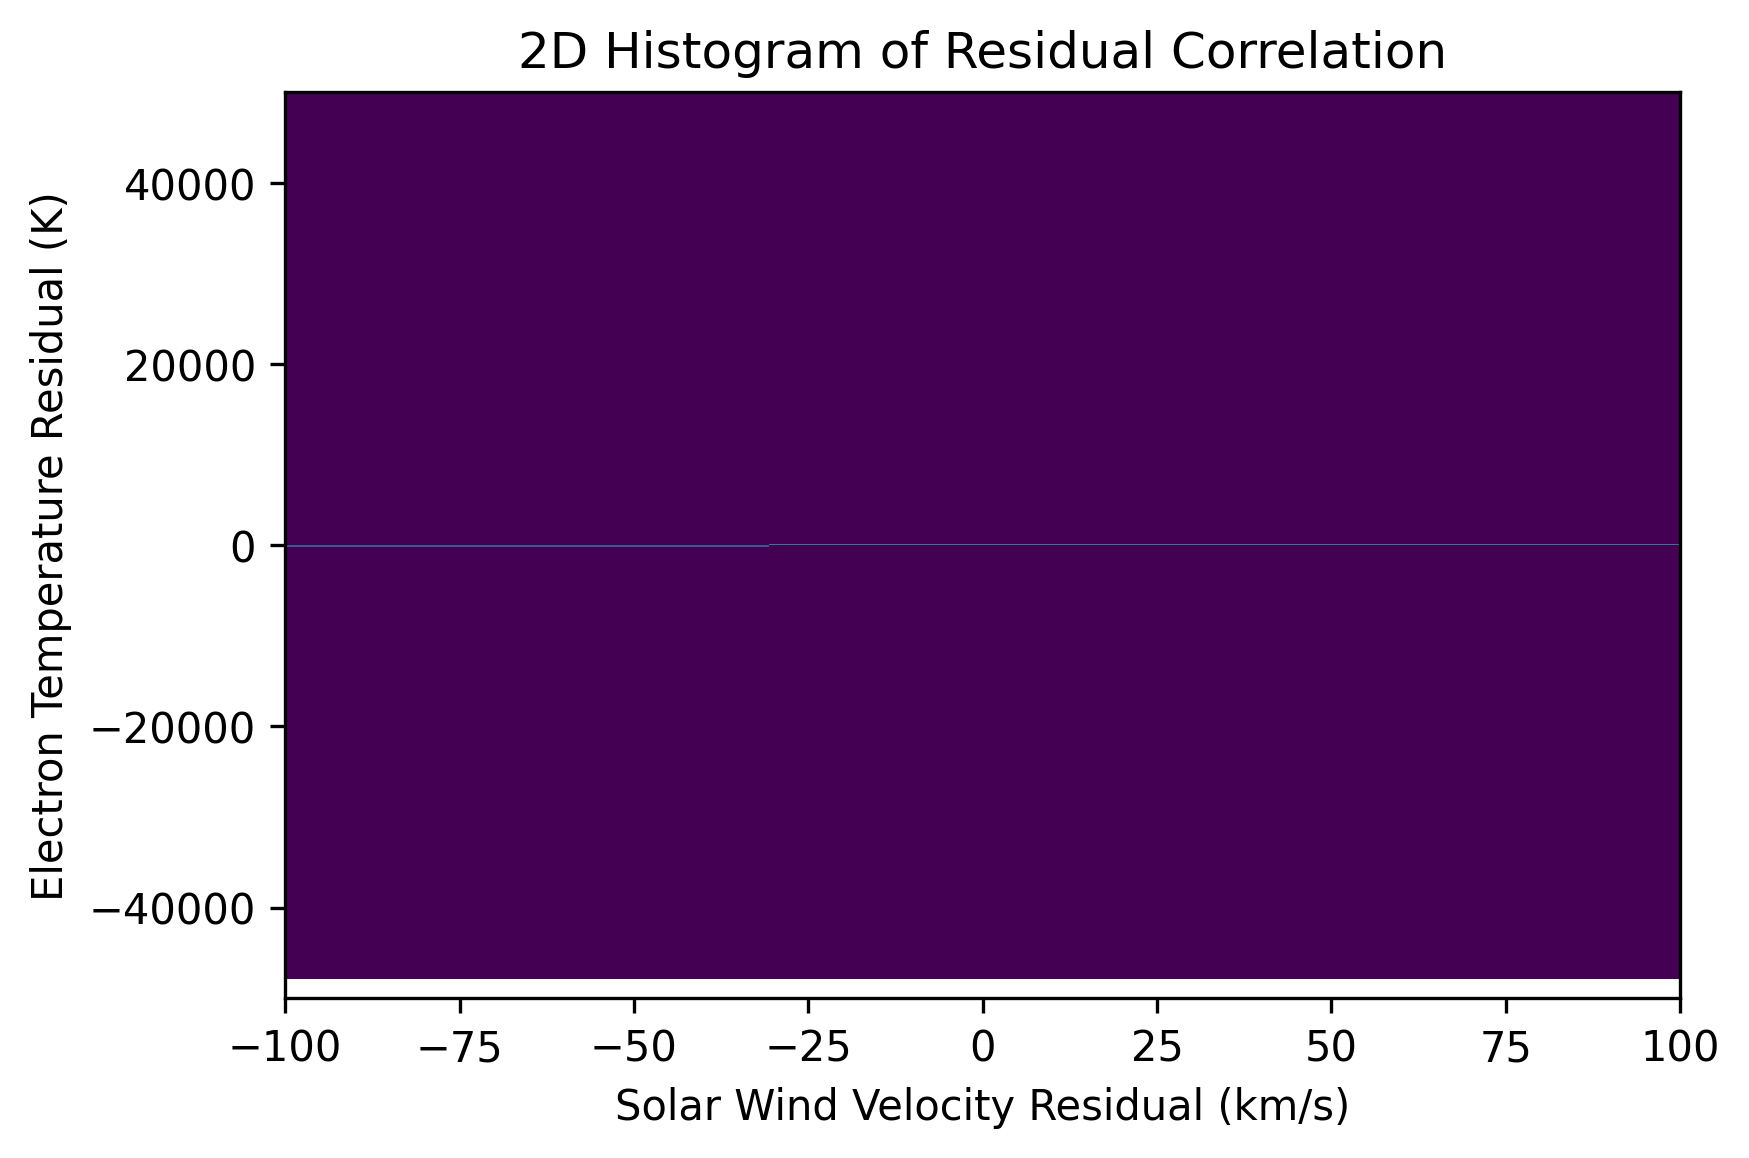

In [24]:
plt.figure(dpi=300, facecolor='w')
plt.hist2d(vsw, te, bins=600)
plt.xlim(-100,100)
plt.ylim(-50000, 50000)
plt.title("2D Histogram of Residual Correlation")
plt.xlabel("Solar Wind Velocity Residual (km/s)")
plt.ylabel("Electron Temperature Residual (K)")
plt.savefig("plots/vsw_te_residual_correlation1.png", dpi=500, pad_inches=1)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


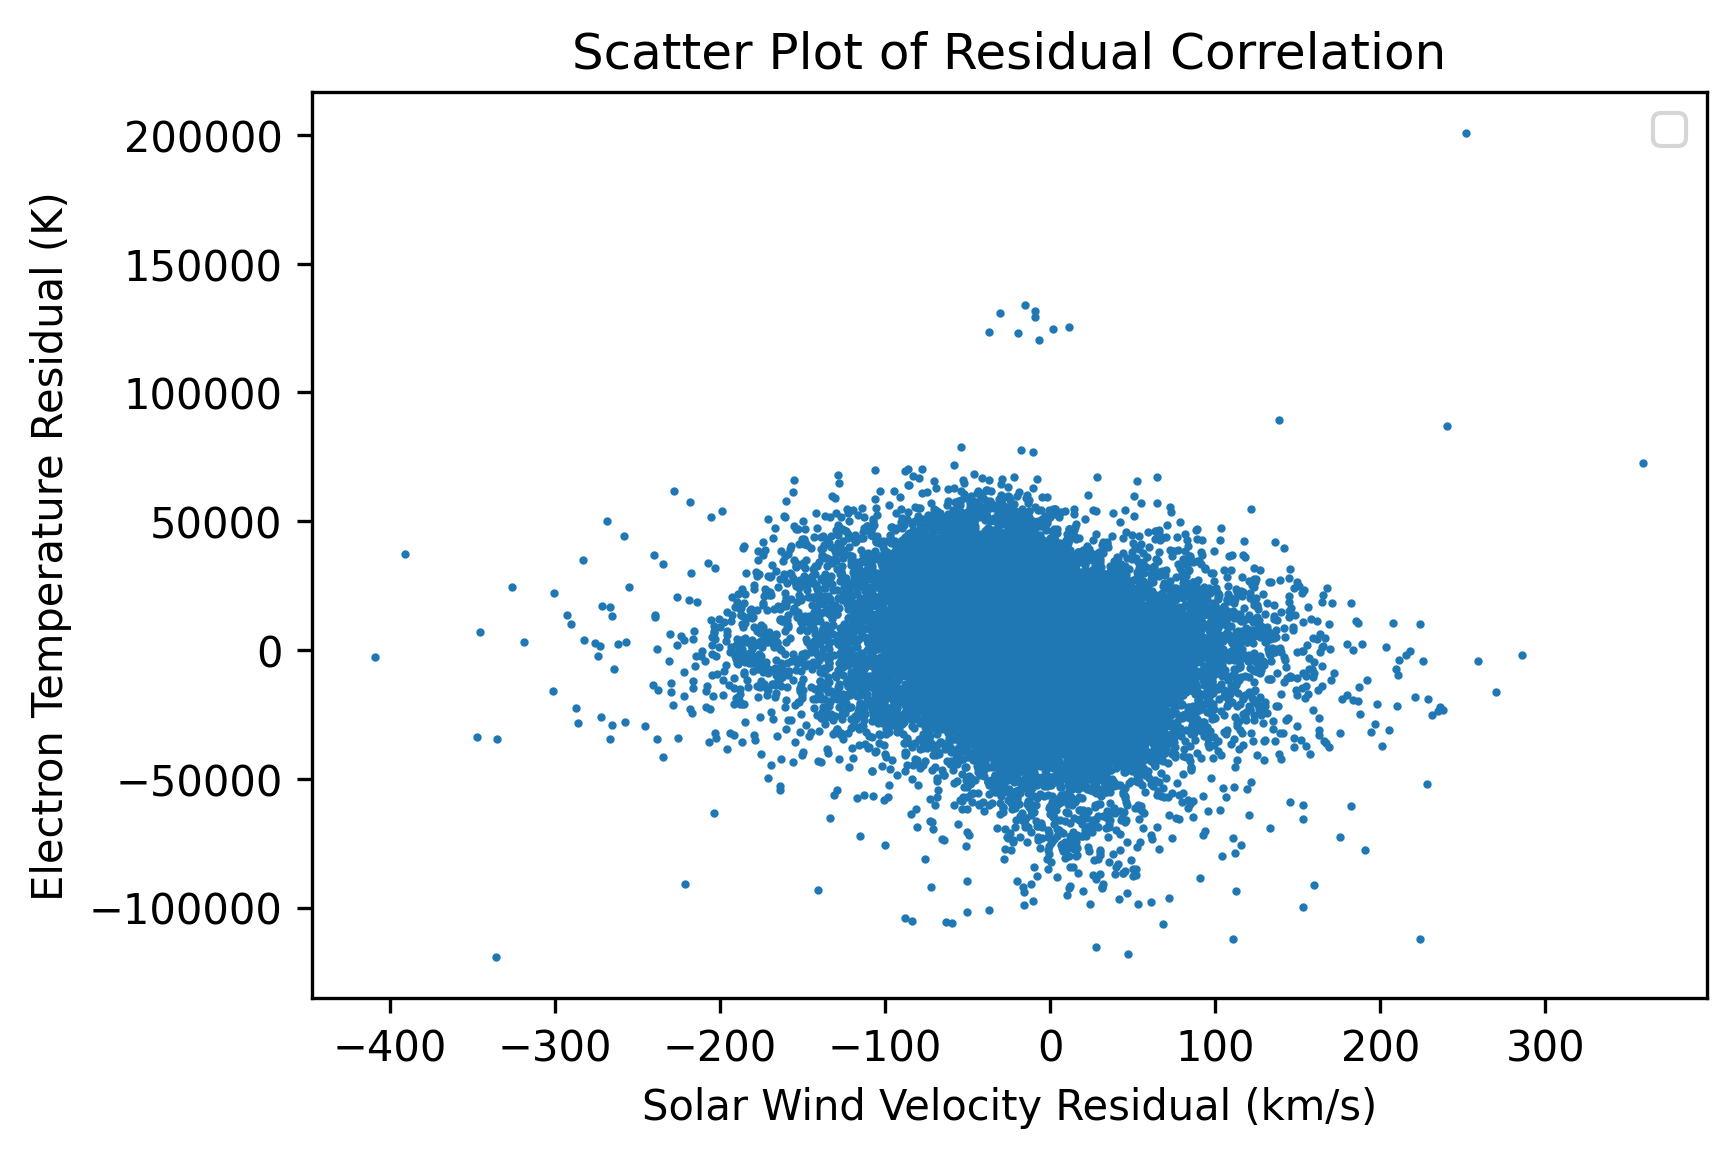

In [56]:
plt.figure(dpi=300, facecolor='w')
plt.scatter(vsw, te, s=1)
plt.title("Scatter Plot of Residual Correlation")
plt.legend()
plt.xlabel("Solar Wind Velocity Residual (km/s)")
plt.ylabel("Electron Temperature Residual (K)")
plt.savefig("plots/vsw_te_residual_correlation2.png", dpi=300)
plt.show()

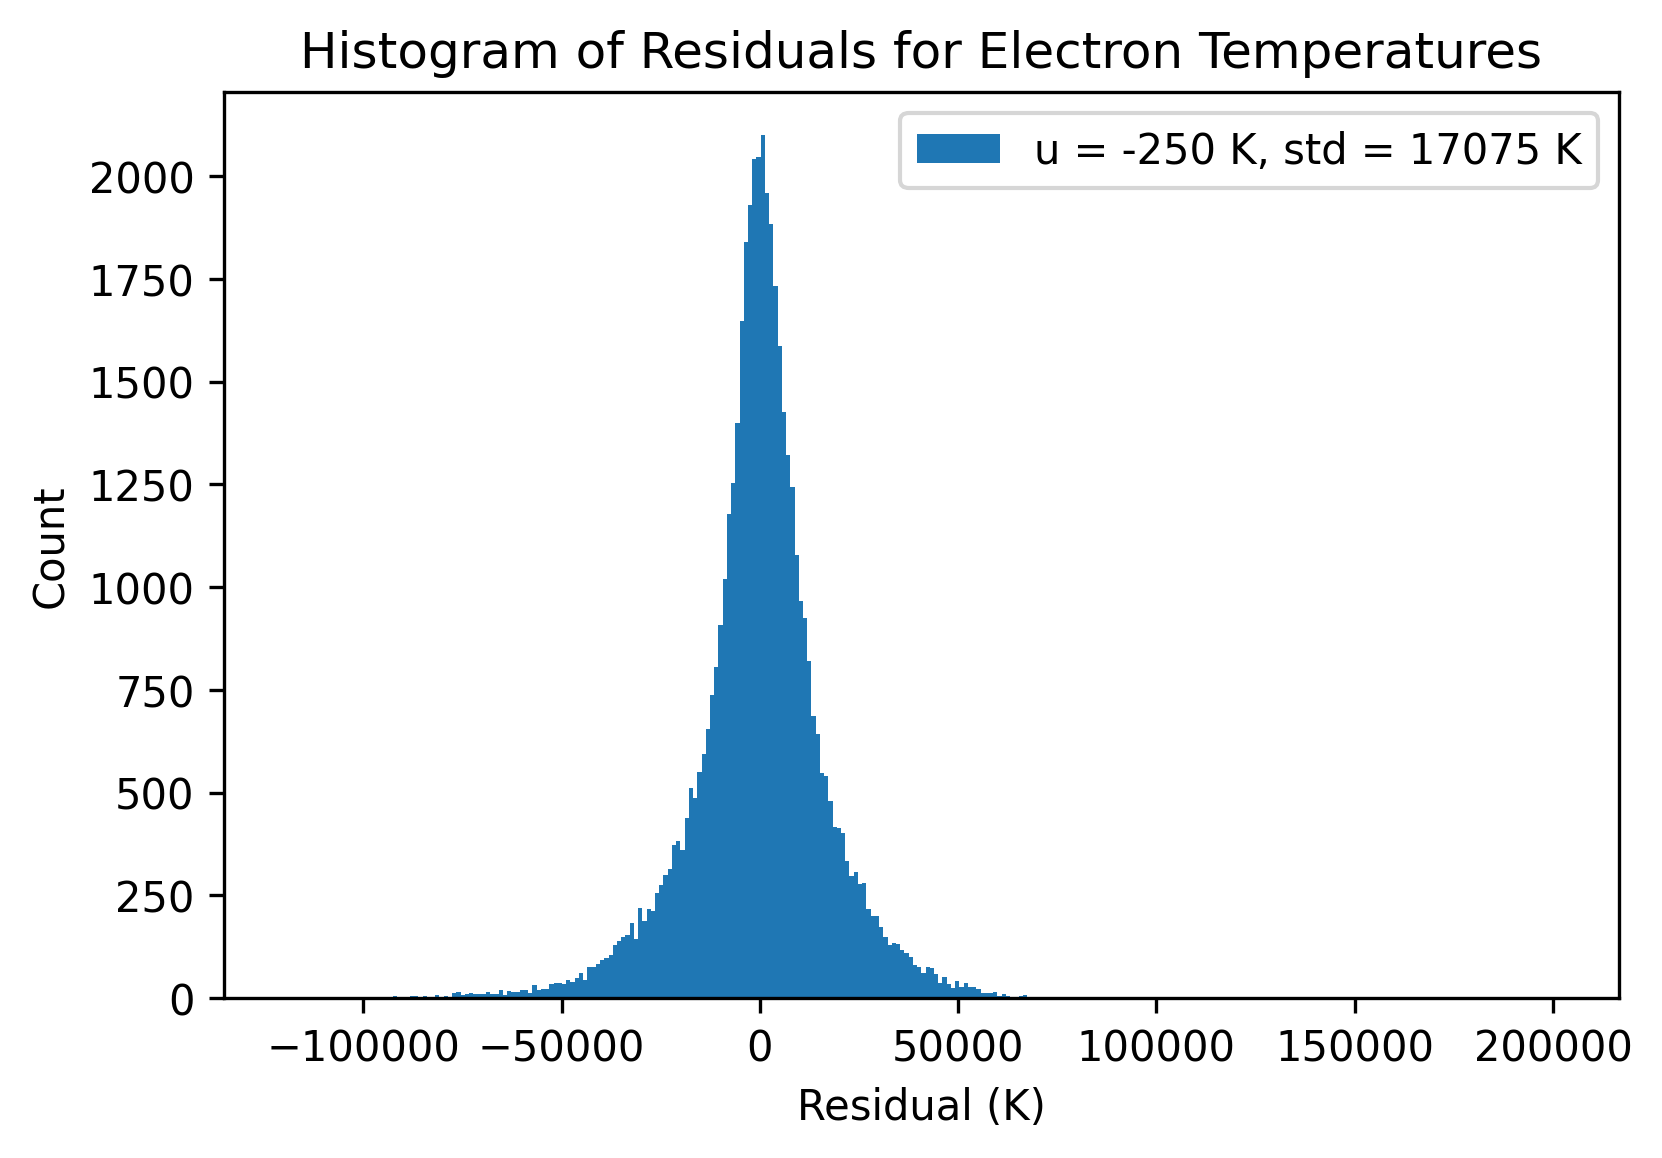

In [28]:
plt.figure(dpi=300, facecolor='w')
plt.hist(lst3, bins=300, label="u = -250 K, std = 17075 K")
plt.title("Histogram of Residuals for Electron Temperatures")
plt.legend()
plt.xlabel("Residual (K)")
plt.ylabel("Count")
plt.savefig("plots/te_residuals.png", dpi=300)
plt.show()

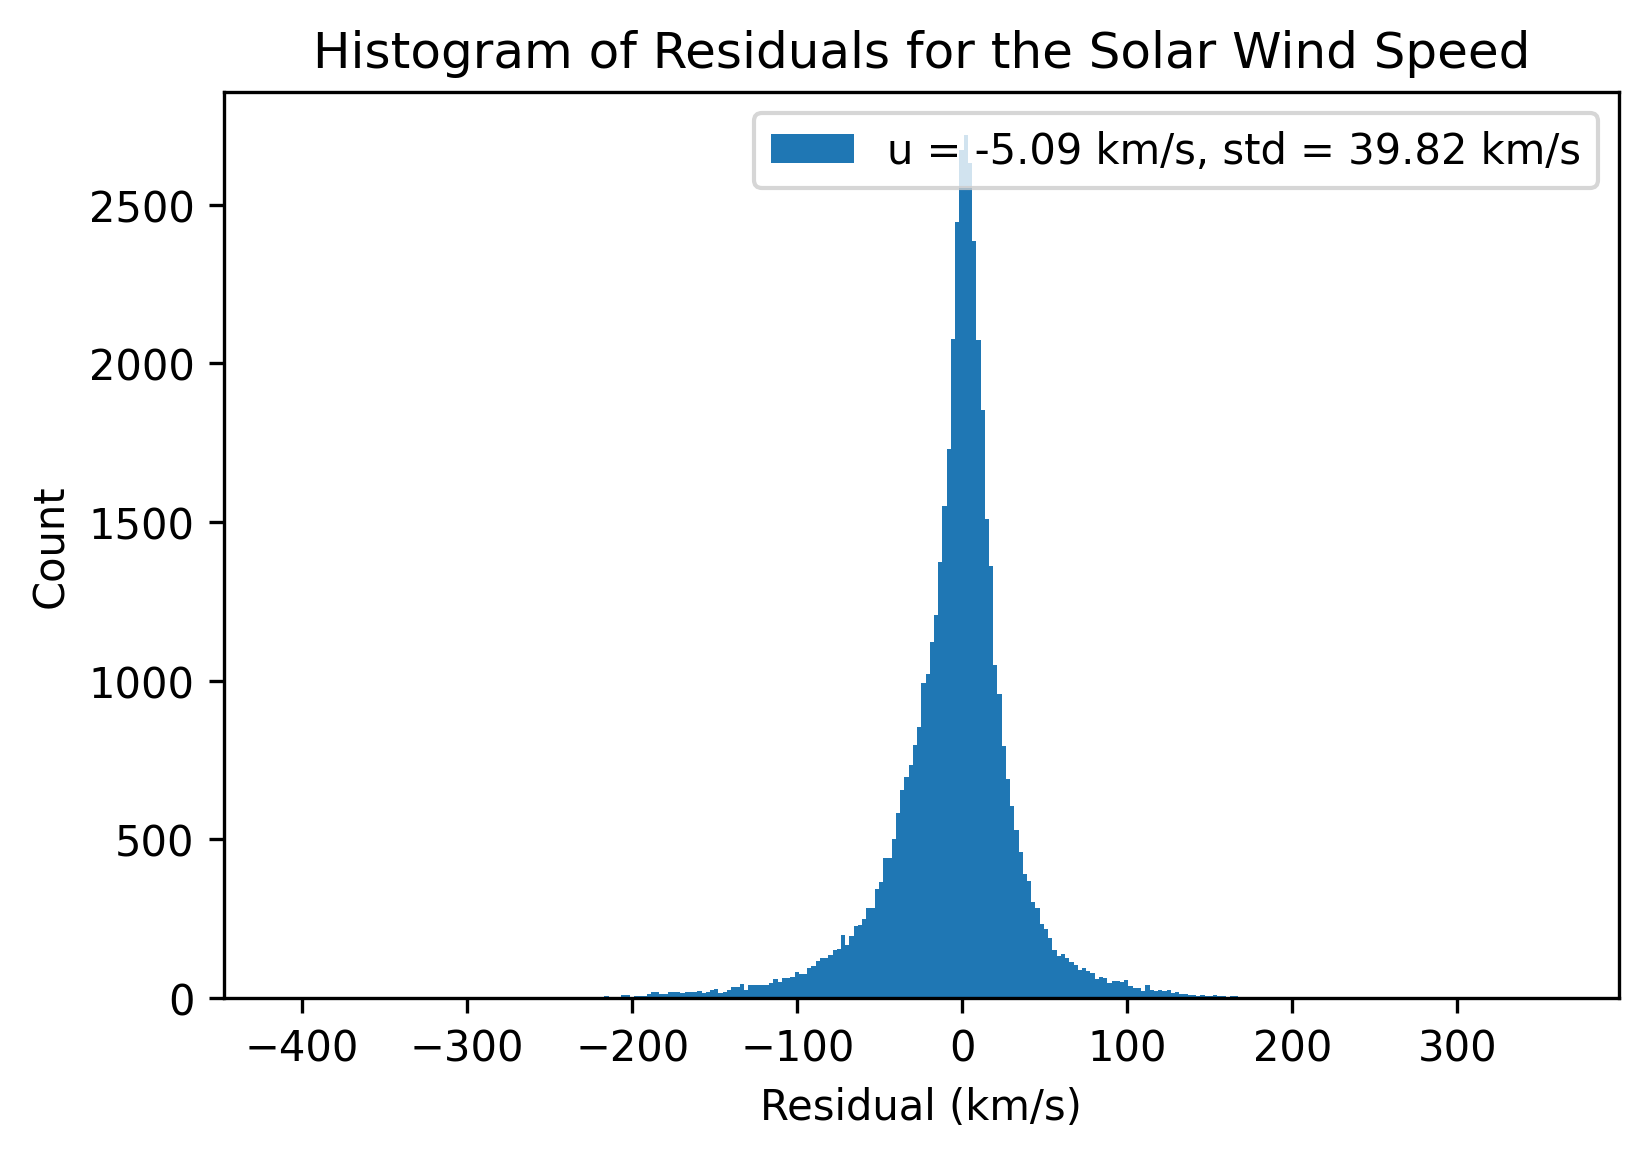

In [20]:
plt.figure(dpi=300, facecolor='w')
plt.hist(lst3, bins=300, label="u = -5.09 km/s, std = 39.82 km/s")
plt.title("Histogram of Residuals for the Solar Wind Speed")
plt.legend()
plt.xlabel("Residual (km/s)")
plt.ylabel("Count")
plt.savefig("plots/vsw_residuals.png", dpi=300)
plt.show()

In [67]:
pd.DataFrame(zip(vsw, te)).corr("spearman")

,0,1
0,1.000000,-0.133842
1,-0.133842,1.000000


In [15]:
pd.DataFrame(test_y_sorted_ed).describe()

,0
count,50573.000000
mean,8.953753
std,6.992553
min,1.822309
25%,4.207715
50%,5.617914
75%,12.416366
max,90.299347


In [16]:
9.505400e-02/np.sqrt(5.057300e+04)

0.0004226793577637358

In [17]:
np.percentile(lst3, 97.25)

0.344555702209473

In [18]:
np.percentile(lst3, 2.25)

-0.5185630607604981

In [19]:
assert continue_after_testing, "Stop After Testing"

AssertionError: Stop After Testing

## Ploting Figures

In [12]:
plot_figs = True
save_figs = True

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.title("Validation Performance after each epoch - MAPE")
    plt.plot(history.history["mean_absolute_percentage_error"], label="Average Error during Training")
    plt.axhline(perf[1], color='g', label="Average Error during Testing")
    plt.xlabel("Epoch (80% of total training data)")
    plt.ylabel("Average Percent Error (%)")
    plt.legend()
    if save_figs:
        plt.savefig(f"plots/validation_performance_over_time_{parameter}.png", dpi=500)

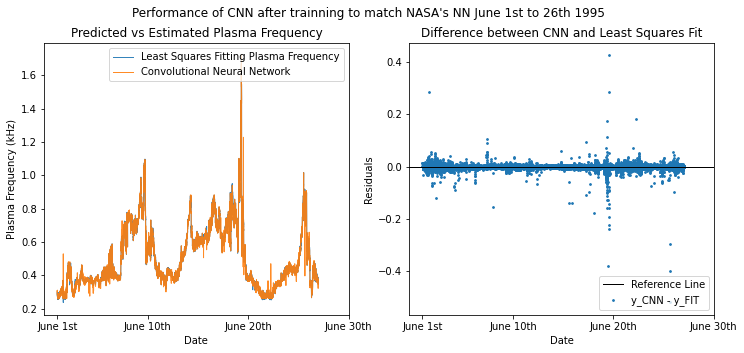

In [30]:
if plot_figs and parameter == "fpe":
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
    fig.suptitle("Performance of CNN after trainning to match NASA's NN June 1st to 26th 1995")

    ax0.plot(test_time_sorted, denorm_test, label="Least Squares Fitting Plasma Frequency",linewidth=1, alpha=.9)
    ax0.plot(test_time_sorted, denorm_pred, label="Convolutional Neural Network",linewidth=1, alpha=.9)
    ax0.set_title("Predicted vs Estimated Plasma Frequency")
    ax0.set_xticks([801964800, 802742400, 803606400, 804470400])
    ax0.set_xticklabels(["June 1st",  "June 10th","June 20th","June 30th"])
    ax0.set_xlabel("Date")
    ax0.set_ylabel("Plasma Frequency (kHz)")
    ax0.legend()

    res = np.subtract(denorm_pred,denorm_test)
    ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
    ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_FIT")
    
    ax1.set_title("Difference between CNN and Least Squares Fit")
    ax1.set_xticks([801964800, 802742400, 803606400, 804470400])
    ax1.set_xticklabels(["June 1st",  "June 10th","June 20th","June 30th"])
    ax1.set_xlabel("Date")    
    ax1.set_ylabel("Residuals")
    ax1.legend(loc='lower right')

    if save_figs:
        fig.savefig(f"plots/performance_on_test_dataset_fpe.png", dpi=500)

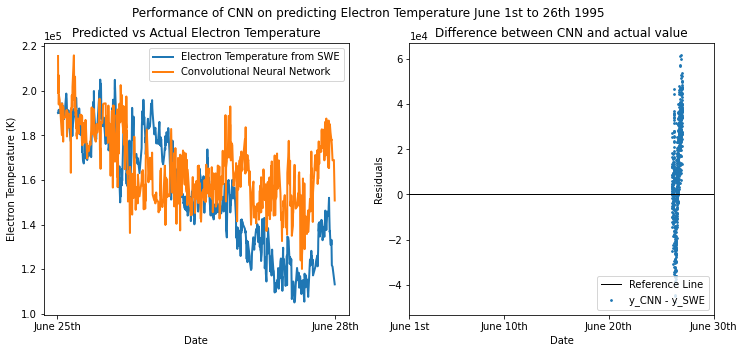

In [27]:
if plot_figs and parameter == "te":
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
    fig.suptitle("Performance of CNN on predicting Electron Temperature June 1st to 26th 1995")

    ax0.plot(test_time_sorted, denorm_test, label="Electron Temperature from SWE",linewidth=2)
    ax0.plot(test_time_sorted, denorm_pred, label="Convolutional Neural Network",linewidth=2)
    ax0.set_title("Predicted vs Actual Electron Temperature")
    ax0.set_xticks([804124800, 804211200])
    ax0.set_xticklabels(["June 25th","June 28th"])
    ax0.set_xlabel("Date")    
    ax0.set_ylabel("Electron Temperature (K)")
    ax0.ticklabel_format(axis='y', scilimits=[0,0])
    ax0.legend()

    res = np.subtract(denorm_pred,denorm_test)
    ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
    ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_SWE")
    
    ax1.set_title("Difference between CNN and actual value")
    ax1.set_xticks([801964800, 802742400, 803606400, 804470400])
    ax1.set_xticklabels(["June 1st",  "June 10th","June 20th","June 30th"])
    ax1.set_xlabel("Date")    
    ax1.set_ylabel("Residuals")
    ax1.ticklabel_format(axis='y', scilimits=[0,0])
    ax1.legend(loc='lower right')

    if save_figs:
        fig.savefig("plots/performance_on_test_dataset_te.png", dpi=500)

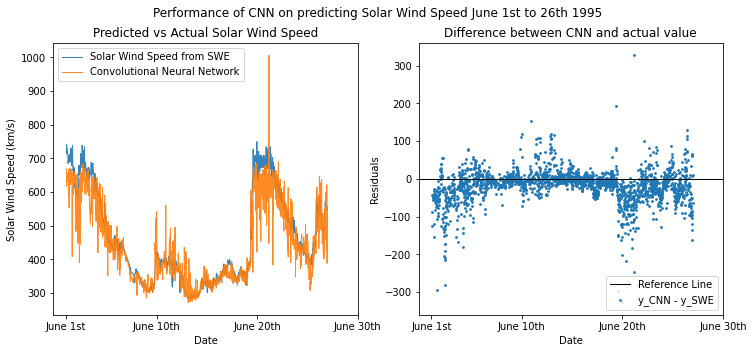

In [40]:
if plot_figs and parameter == "vsw":
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
    fig.suptitle("Performance of CNN on predicting Solar Wind Speed June 1st to 26th 1995")

    ax0.plot(test_time_sorted, denorm_test, label="Solar Wind Speed from SWE",linewidth=1, alpha=.9)
    ax0.plot(test_time_sorted, denorm_pred, label="Convolutional Neural Network",linewidth=1, alpha=.9)
    ax0.set_title("Predicted vs Actual Solar Wind Speed")
    ax0.set_xticks([801964800, 802742400, 803606400, 804470400])
    ax0.set_xticklabels(["June 1st",  "June 10th","June 20th","June 30th"])
    ax0.set_xlabel("Date")    
    ax0.set_ylabel("Solar Wind Speed (km/s)")
    ax0.legend()

    res = np.subtract(denorm_pred,denorm_test)
    ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
    ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_SWE")
    
    ax1.set_title("Difference between CNN and actual value")
    ax1.set_xticks([801964800, 802742400, 803606400, 804470400])
    ax1.set_xticklabels(["June 1st",  "June 10th","June 20th","June 30th"])
    ax1.set_xlabel("Date")    
    ax1.set_ylabel("Residuals")
    ax1.legend(loc='lower right')

    if save_figs:
        fig.savefig("plots/performance_on_test_dataset_vsw.png", dpi=500)

In [ ]:
if plot_figs and False:
    # Not exactly sure of the purpose of this code
    def norm_dist(val, mean=np.mean(lst3), standard_dev=np.std(lst3)):
        factor = 1/np.sqrt(2*np.pi*(standard_dev**2))
        exp = np.exp(-(val - mean)**2/(2*(standard_dev**2)))
        return factor*exp

    x = [-2 + i*.1 for i in range(40)]
    y = [norm_dist(v)*3000 for v in x]

In [ ]:
if plot_figs:
    fig, ax = plt.subplots(facecolor='w')
    ax.hist(lst3, 1000, histtype='bar')
    #ax.set_xlim(-3,3)
    ax.set_title("Histogram of residual distribution - MAPE")
    ax.set_xlabel("Residual (kHz)")
    ax.set_ylabel("Number of Occurences")
    ax.set_yscale("log")
    #ax.plot(x,y)
    if save_figs:
        plt.savefig(f"plots/hist_error_{parameter}.png", dpi=500)

In [ ]:
assert False

In [ ]:
# Finding all outliers with a frequency error greater than 5
data_zip = list(filter(lambda x: abs(x[4])>10, zip(test_time_sorted, test_x_sorted, test_y_sorted, pred_y, res)))
test_time_sorted_outliers, test_x_sorted_outliers, test_y_sorted_outliers, pred_y_outliers, res_outliers = list(zip(*data_zip))

In [ ]:
# data_zip2 = list(filter(lambda x: abs(x[4])<.00003, zip(test_time_sorted, test_x_sorted, test_y_sorted, pred_y, res)))
# test_time_sorted_best, test_x_sorted_best, test_y_sorted_best, pred_y_best, res_best = list(zip(*data_zip2))

In [ ]:
if plot_figs:
    n = len(res_outliers)
    #plt.figure(figsize=(15, 4*n))
    fig, ax = plt.subplots(nrows=n, figsize=(9, 3*n), facecolor='w', dpi=200)

    for i in range(0, n):    
        ax[i].set_ylabel("V^2/Hz")
        ax[i].set_xlabel("Frequency (kHz)")
        ax[i].xaxis.set_label_coords(.5, -.04)
        ax[i].scatter(freq/1000, denorm(test_x_sorted_outliers[i], max_y), s=6,label='WIND data')
        ax[i].plot(freq/1000, denorm(test_x_sorted_outliers[i], max_y), markersize=1,label='WIND data')

        ax[i].axvline(x=denorm(pred_y_outliers, max_y)[i], color='r', label="CNN")
        ax[i].axvline(x=denorm(test_y_sorted_outliers, max_y)[i], color='g', label="NASA estimate")
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_ylim(1, 550)
        ax[i].set_xlim(3.5, 275)
        ax[i].set_aspect(.2)
        ax[i].text(4, 300, f"Plot #{i+1} - Residual: {np.round(res_outliers[i],2)}")
        ax[i].legend()

    fig.suptitle("The plot of the spectra with CNN and NASA estimate for plasma frequency", y=0.888)
    if save_figs:
        plt.savefig("plots/outliers.png", dpi=fig.dpi, bbox_inches='tight')


In [ ]:
if plot_figs:
    plt.figure(facecolor='w',figsize=(5,5))
    plt.scatter(denorm_test*50, lst3, s=.1)
    plt.axhline(0, color='#000000')
    plt.xlabel("Plasma Frequency (kHz)")
    plt.ylabel("Actual Value")
    if save_figs:
        plt.savefig("plots/plot_residual_vs_freq.png")

In [ ]:
if plot_figs:
    plt.figure(figsize=(8,8), facecolor='w')
    plt.hist2d(denorm_pred, denorm_test, bins =[100, 100], density=True,cmap = plt.cm.Greys)
    plt.colorbar()
    if save_figs:
        plt.savefig("plots/2dhist3.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')

    plt.title("Histogram of NASA's NN Plasma Frequency Predictions")
    plt.hist(denorm_test, bins=80)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Number of occurences")
    if save_figs:
        plt.savefig("plots/hist_nasa_nn_plasma_freq.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')

    plt.title("Histogram of CNN Plasma Frequency Predictions")
    plt.hist(denorm_pred, bins=80)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Number of occurences")
    if save_figs:
        plt.savefig("plots/hist_cnn_plasma_freq.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.scatter(denorm_test, lst3, s=1)
    plt.axhline(0, color='r', linewidth=.5)
    plt.xlabel("NASA Predicted Plasma Frequency (kHz)")
    plt.ylabel("Residuals (kHz)")
    plt.title("Comparing change in residuals for each respective plasma frequency")
    if save_figs:
        plt.savefig("plots/residual_and_nasa_plasma_freq", dpi=500)
    plt.show()

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.hist2d(denorm_test, lst3, bins=[100,100])
    plt.xlabel("NASA's NN Plasma Frequency (kHz)")
    plt.ylabel("Residuals")
    plt.colorbar()
    if save_figs:
        plt.savefig("plots/resvsfp1.png")

## Conditional Probablity Distribution

In [ ]:
plotCPDfig = False

In [ ]:
if plotCPDfig:
    count = 0
    diff = 1.5
    int_denorm_test = np.array([int(f) for f in denorm_test])
        
    dist_error = np.array([[0,0] for _ in range(85)])

    for fpe in range(85):
        y_list = []
        
        for findex in np.where(int_denorm_test-fpe<.001)[0]:
            f = denorm_test[findex]
            indices = np.where(np.abs(denorm_pred-f)<diff)[0]
            y_list.extend(np.add(denorm_pred[indices],-f))
        
        if y_list:
            dist_error[fpe] = [np.mean(y_list), np.std(y_list)]

        if count%1==0:
            progress_bar(count/85)
        count += 1

In [ ]:
pd.DataFrame(int_denorm_test).describe()

In [ ]:
if plotCPDfig:
    with open("data/pickle/error_dist", 'rb') as file:
        data_dic = pickle.load(file=file)

    denorm_pred = np.array(data_dic["Pred_y"])
    denorm_test = np.array(data_dic["Act_y"])

    del(data_dic)
    gc.collect()

In [ ]:
if plotCPDfig:

    diff = 1.5
    count = 0

    hist2dlist = np.array([np.array([0 for _ in range(100)]) for _ in range(85)])

    print("Started")
    for f in denorm_test:
        indices = np.where(np.abs(denorm_pred-f)<diff)[0]
        
        x = int(f)
        y_list = np.multiply(np.add(denorm_pred[indices],1.5-f), 100/3)

        for y in y_list:
            # count up the x and y coords 
            hist2dlist[x, int(y)] += 1
            
        if count%5000==0:
            print(count)
        count += 1
    


In [ ]:
if plotCPDfig:

    cleanhist2dlist = hist2dlist[12:85]

    group = 3
    hist2dlist3 = []

    for i in range(len(cleanhist2dlist)//group):
        hist2dlist3.append(np.sum(cleanhist2dlist[group*i:group*i+group], axis=0))

    hist2dlist4 = np.array(hist2dlist3)

    # for i in range(int(len(hist2dlist4)/2),len(hist2dlist4),2):

    #     blur = 2

    #     if i+index>len(hist2dlist4):
    #         break
    #     sum_hist = hist2dlist4[i]
    #     for index in range(1,blur):
    #         sum_hist += hist2dlist4[i+index]
    #     for index in range(blur):
    #         hist2dlist3[i+index] = sum_hist
    

In [ ]:
if plotCPDfig:

    hist2dlist2 = [np.array(row[:]) for row in hist2dlist4]

    # for i in range(len(hist2dlist2)):
    #     if i>45 and False: # modify False/True if want to disable blur
    #         blur = 5#int(i/20+1)
    #         for j in range(len(hist2dlist2[i])):
    #             section = 5#j//blur 
    #             #sum_section = sum(hist2dlist[i,section*blur:section*blur+blur])
    #             try:
    #                 hist2dlist2[i][j] = sum(hist2dlist[i,j:j+blur])
    #             except IndexError:
    #                 length = len(hist2dlist2[i])
    #                 hist2dlist2[i][j] = sum(hist2dlist[i,length-blur:length])

    for i in range(len(hist2dlist2)):
        min_val = min(hist2dlist2[i])
        range_val = max(*hist2dlist2[i], 1) - min(hist2dlist2[i])
        hist2dlist2[i] = np.divide(np.subtract(hist2dlist2[i], min_val), range_val)

In [ ]:
if plotCPDfig:

    fig, ax = plt.subplots(facecolor='w', figsize=(8,5))

    colors = ["#ffffff","#0000ff"]
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

    psm = ax.pcolormesh(np.transpose(hist2dlist2),cmap = cmap1)#, norm=matplotlib.colors.LogNorm())
    #ax.set_xlim((12,85))

    tickmarks = [-1.5,-1,-.5,0,.5,1]
    ax.set_yticks(np.arange(0,100,100/len(tickmarks)))#[0,10,20,30,40,50,60,70,80,90])
    ax.set_yticklabels(tickmarks)

    tickmarks = np.round(np.array(list(range(1,24,5)))*3+12,1)
    ax.set_xticks(np.arange(1,len(hist2dlist2),len(hist2dlist2)/len(tickmarks)))
    ax.set_xticklabels(tickmarks)

    fig.colorbar(psm)

    ax.set_title("Conditional Probability Distribution for NASA's NN vs CNN Residuals")
    ax.set_xlabel("NASA's NN Plasma Frequency (kHz)")
    ax.set_ylabel("Residuals (kHz)")

    plt.savefig("plots/conditional_probability_distribution.png")
    plt.show()

## Pickle Stuff

In [ ]:
# with open("data/pickle/conditional_probx", 'rb') as file:
#     x = pickle.load(file=file)
    
# with open("data/pickle/conditional_proby", 'rb') as file:
#     y = pickle.load(file=file)

In [ ]:
# with open("data/pickle/conditional_probx", 'wb') as file:
#     pickle.dump(x, file=file)
# with open("data/pickle/conditional_proby", 'wb') as file:
#     pickle.dump(y, file=file)